# 1 Modeling Volatiliy

Find data for historical prices for any publicly traded equity. To ensure the length of data, use daily data for at least 3 years. Fit the historical data to

1. Geometric Brownian motion
2. Any non-constant volatility model

Find market data for option prices for this stock. Use option prices to

3. Show volatility smile
4. Construct term structure of volatility
5. Plot the volatility surface, as a function of time to maturity and moneyness 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pybroker
import yfinance as yf
from pybroker.data import DataSource
from pybroker.ext.data import AKShare
import warnings
from pylab import mpl
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-white')
mpl.rcParams['savefig.dpi'] = 300 # 分辨率为300
mpl.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


In [2]:
STRAT_DATE = '2021-01-01'
END_DATE = '2024-09-30'
MSFT = yf.Ticker('MSFT') 

## Constant Volatility
If the stock price follows **Geometric Brownian Motion**, then 
$$
\begin{aligned}
d\ln(S)=\left( \mu-\frac{1}{2}\sigma^{2} \right)dt+\sigma dB
\end{aligned}
$$
hence 
$$
\begin{gathered}
\Delta \ln S =\quad\left(\mu-\frac12\sigma^2\right)\Delta t+\sigma\Delta B \\
\ln S(t_i)-\ln S(t_{i-1}) =\quad\left(\mu-\frac12\sigma^2\right)\Delta t+\sigma(B(t_i)-B(t_{i-1})) \\
\frac{\ln S(t_i)-\ln S(t_{i-1})}{\sqrt{\Delta t}} =\quad\left(\mu-\frac12\sigma^2\right)\sqrt{\Delta t}+\sigma\frac{B(t_i)-B(t_{i-1})}{\sqrt{\Delta t}} 
\end{gathered}
$$
here we let $\Delta t=1\text{ day }= 1/252 \text{ year }$ , let $y_{i}=\frac{\ln S(t_{i})-\ln S(t_{i-1})}{\sqrt{ \Delta t }}$, then 
$$
\begin{aligned}
\hat{\sigma}^{2}& =\frac{1}{N-1}\left(\sum_{i=1}^{N}y_{i}^{2}-N\bar{y}^{2}\right) \\
\end{aligned}
$$
and 
$$
\hat{\mu}=\bar{y}+\frac{1}{2}\hat{\sigma}^{2}
$$

In [3]:
# read local data
df = pd.read_csv('MSFT_stock_data.csv', index_col=0)
df.set_index('date', inplace=True)

# calculate log returns
delta_t = 1 / 252
df['y'] = np.log(df['close'] / df['close'].shift(1)) / np.sqrt(delta_t)
df.dropna(inplace=True)

# estimate parameters
y_bar = df['y'].mean()
N = len(df)
sigma_hat = np.std(df['y'])
# mu_hat = y_bar + 1 / 2 * sigma_hat ** 2

print(f"sigma_hat = {sigma_hat:.4f}")

sigma_hat = 0.2637


## GARCH Model

We use GARCH(1, 1) model to fit $y_{i}$, to get our conditional variance

In [4]:
import arch
garch_model = arch.arch_model(df['y'], vol='garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')
df['GARCH_volatility'] =(garch_fit.conditional_volatility)
garch_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -30.2153
Distribution:                  Normal   AIC:                           68.4307
Method:            Maximum Likelihood   BIC:                           87.8099
                                        No. Observations:                  939
Date:                Wed, Oct 16 2024   Df Residuals:                      938
Time:                        08:37:16   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0166  7.537e-03      2.198  2.797e-02 [1.791e-03,3.133e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      3.2710e-04  2.753e-04      1.188      0.235 [-2.125e-04,8.668e-04]
alpha[1]       0.0323  8.667e-03      3.725  1.957e-04  [1.529e-02,4.927e-02]
beta[1]        0.9627  1.025e-02     93.962      0.000      [  0.943,  0.983]
=============================================================================

Covariance estimator: robust
"""

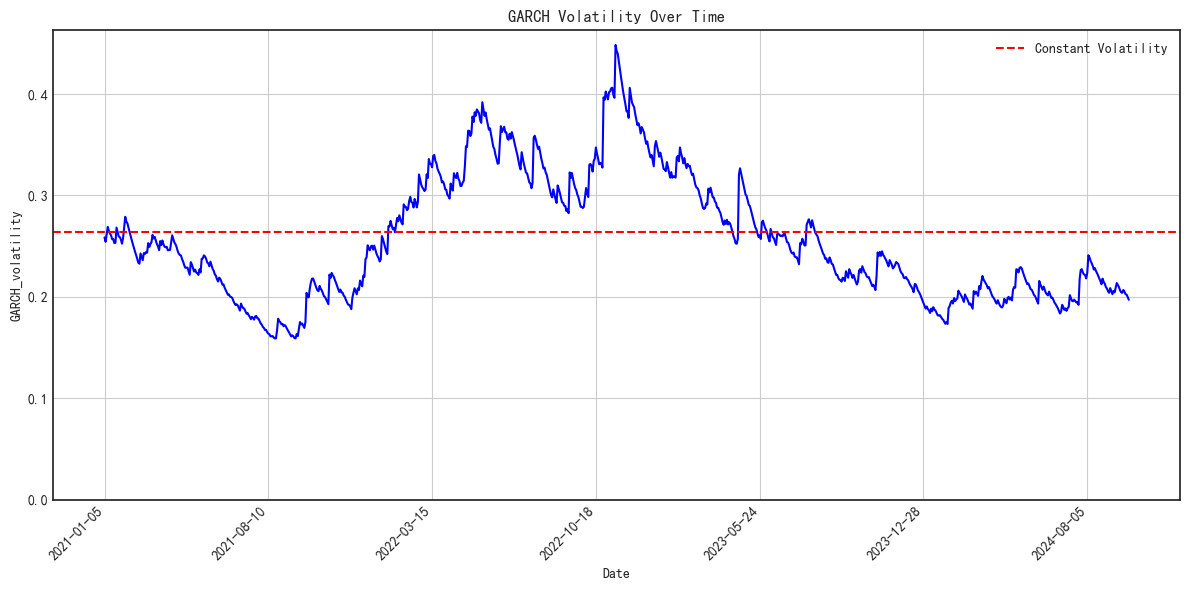

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df[['GARCH_volatility']], linestyle='-', color='b')
plt.axhline(y=sigma_hat, color='r', linestyle='--', label='Constant Volatility')
plt.ylim(0)
plt.xlabel('Date')
plt.ylabel('GARCH_volatility')
plt.title('GARCH Volatility Over Time')
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Reduce the number of x-axis labels
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

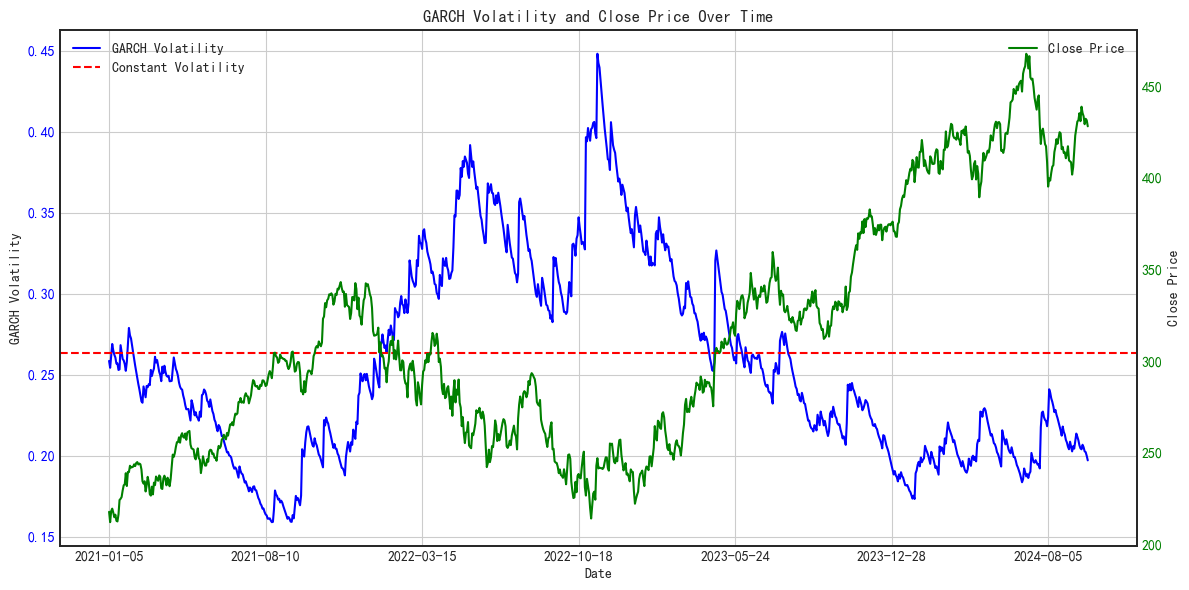

In [6]:
plt.figure(figsize=(12, 6))

ax1 = plt.gca()
ax1.plot(df.index, df['GARCH_volatility'], linestyle='-', color='b', label='GARCH Volatility')
ax1.axhline(y=sigma_hat, color='r', linestyle='--', label='Constant Volatility')
ax1.set_xlabel('Date')
ax1.set_ylabel('GARCH Volatility')
ax1.tick_params(axis='y', labelcolor='b')  
ax1.grid()
ax1.legend(loc='upper left')    


ax2 = ax1.twinx()
ax2.plot(df.index, df['close'], linestyle='-', color='g', label='Close Price')
ax2.set_ylabel('Close Price')
ax2.tick_params(axis='y', labelcolor='g')  
ax2.legend(loc='upper right')


plt.xticks(rotation=45, ha='right')
ax1.xaxis.set_major_locator(plt.MaxNLocator(10))  


plt.title('GARCH Volatility and Close Price Over Time')
plt.tight_layout()

plt.show()

## Volatility Smile

Find the today's call option data of MSFT, there are 21 different options. The expiration ranges from 2024 - 10 - 18 to 2027-01-15

The *TTM* ( time to maturity) needs to be converted to years, so each is divided by 365 

Since there are outliers in *impliedVolatility*, so we only keep those who changes less than 50% to plot the smile picture. And we draw a picture every five expirations 

In [16]:
def get_option_info(expirations, tk):
    df = pd.DataFrame()
    for expiration in expirations:
        option = tk.option_chain(expiration)
        new_df = option.calls
        new_df['expiration'] = pd.to_datetime(expiration)
        df = pd.concat([df, new_df])
    return df

df_option = get_option_info(MSFT.options, MSFT)
# df_option.to_csv('option.csv')

In [25]:
df_option = pd.read_csv('option.csv') #Data was collected on 2024-10-16

# choose the option date
option_columns = ['expiration', 'strike', 'lastPrice', 'impliedVolatility']
df_option = df_option[option_columns]
df_option['expiration'] = pd.to_datetime(df_option['expiration'])

# calculate time to maturity (in years)
df_option['TTM'] = (df_option['expiration'] - pd.Timestamp('2024-10-16')).dt.days 
df_option['TTM'] = df_option['TTM'] / 365 # convert days to years

df_option['moneyness'] = df_option['lastPrice'] / df_option['strike']

# exclude options with implied volatility change over 50% and less than 1%
df_option = df_option[df_option['impliedVolatility'] > 0.01]
# df_option = df_option[df_option['impliedVolatility'].pct_change() < 0.5]

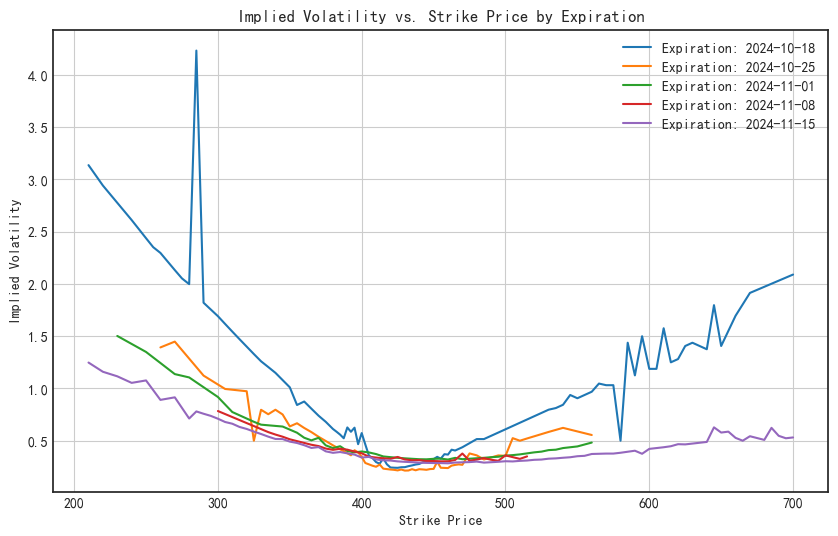

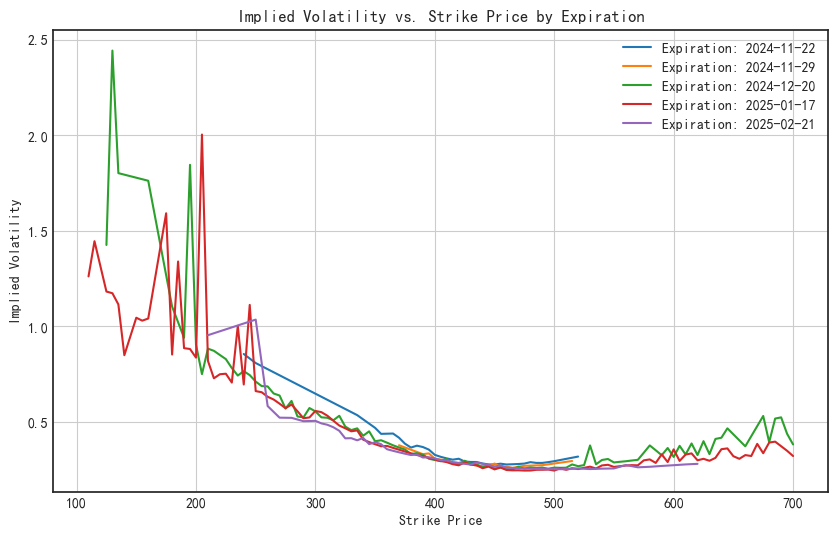

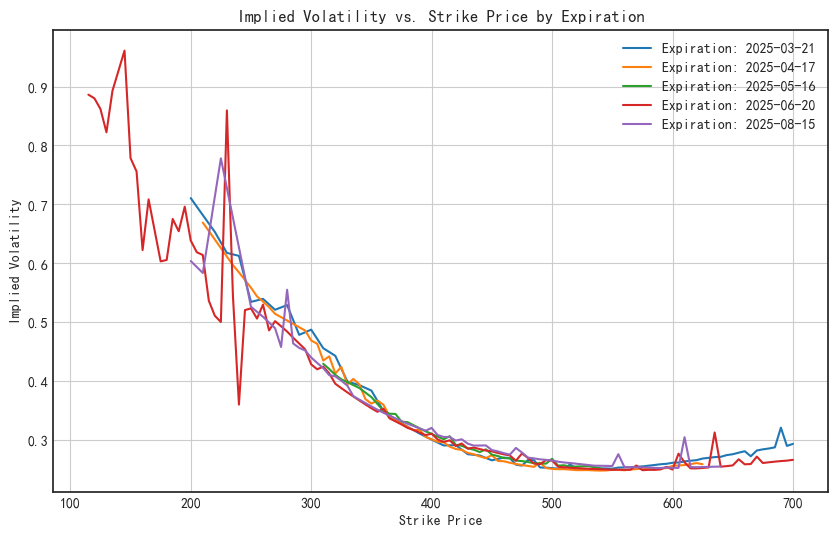

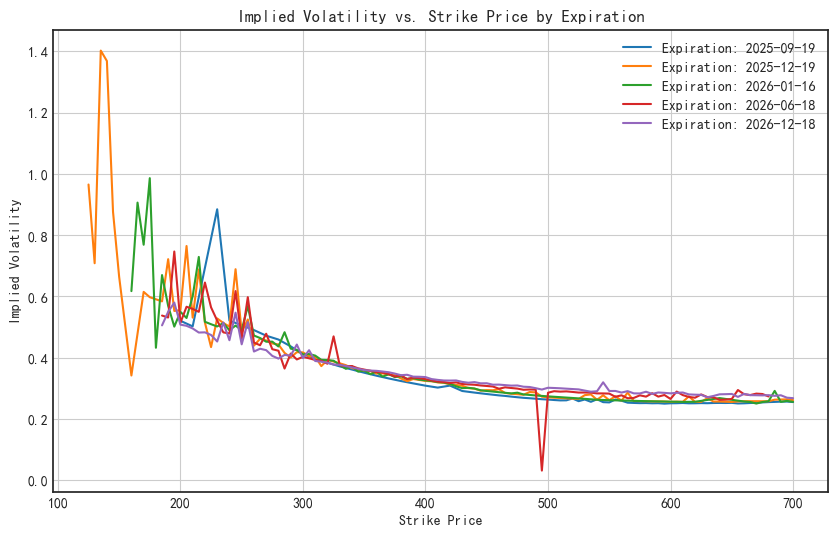

In [26]:
for i, (expiration, group) in enumerate(df_option.groupby('expiration')):
    if i == 20:
        continue
    if i % 5 == 0:
        plt.figure(figsize=(10, 6))
    plt.plot(group['strike'], group['impliedVolatility'], marker='', linestyle='-', label=f"Expiration: {expiration.strftime('%Y-%m-%d')}")
    if i % 5 == 4:
        plt.xlabel('Strike Price')
        plt.ylabel('Implied Volatility')
        plt.title('Implied Volatility vs. Strike Price by Expiration')
        plt.legend()
        plt.grid(True)
        plt.show()

## Term Structure of Volatility

In [10]:
df_option['strike'].mode()

0    370.0
1    400.0
2    410.0
3    420.0
4    430.0
5    440.0
6    450.0
7    460.0
8    470.0
Name: strike, dtype: float64

In [11]:
def term_strcture(strike):
    df = df_option[df_option['strike'] == strike]
    df.sort_values(by='TTM').reset_index(drop=True)
    df['strcture'] = np.sqrt(\
        (df['impliedVolatility'] ** 2 * df['TTM'] -\
        (df['impliedVolatility'].shift(1) ** 2 * df['TTM'].shift(1)))/\
        (df['TTM'] - df['TTM'].shift(1)))
    df['strcture'].fillna(df['impliedVolatility'].iloc[0], inplace=True)
    return df[['TTM', 'strcture']]
strcture_volatility = term_strcture(strike=370)

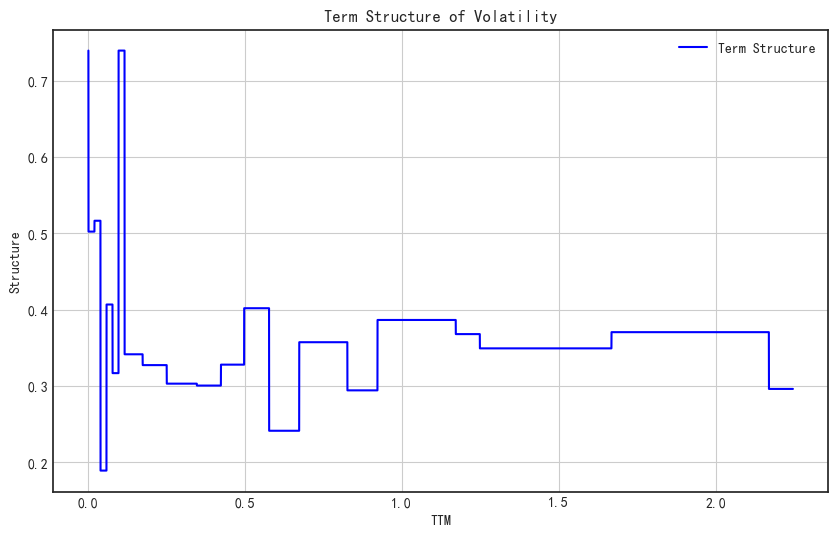

In [12]:
def draw_term_structure(strcture_volatility):

    df = pd.DataFrame((np.arange(strcture_volatility['TTM'].min(), strcture_volatility['TTM'].max(), 0.0001)), columns=['TTM'])
    df = pd.concat([df, strcture_volatility]).sort_values(by='TTM')
    df.fillna(method='bfill', inplace=True)
    plt.figure(figsize=(10, 6))
    plt.plot(df['TTM'], df['strcture'], marker='', linestyle='-', color='b', label='Term Structure')
    plt.xlabel('TTM')
    plt.ylabel('Structure')
    plt.title('Term Structure of Volatility')
    plt.grid(True)
    plt.legend()
    plt.show()

draw_term_structure(strcture_volatility)

## Volatility Surface

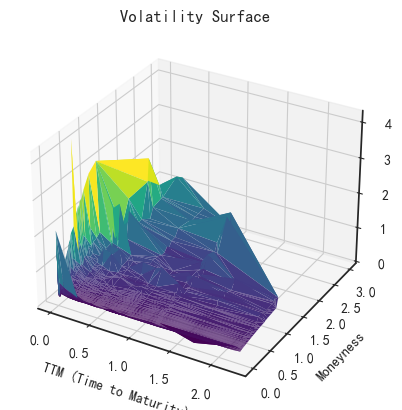

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_trisurf(df_option['TTM'], df_option['moneyness'], df_option['impliedVolatility'], cmap='viridis')

ax.set_ylabel('Moneyness')
ax.set_xlabel('TTM (Time to Maturity)')
ax.set_zlabel('Implied Volatility')

plt.title('Volatility Surface')
plt.show()